In [1]:
#Split location-only results by MA and cone angle, then go into those bins and pull out some spectra

import pandas as pd
import numpy as np
import datetime as dt
import glob

from XMA_finder import XMA_finder
from histo_plot_lower_vmax import histo_plot
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

#import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib
from merka05_surface_eq_array_GIPM import merka05_surface_eq_array_GIPM
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker

In [30]:
#now produce a binned plot of integrated power!first split into bins and then plot
#change to do mean of ratios not ratio of means

def bin_lister_fourier(cluster_df):
    
    #first mask out datapoints so only those within -5<Z<5 Re are left
    
    cluster_df_XY = cluster_df.loc[(cluster_df['GIPM Z']> -5) & (cluster_df['GIPM Z'] < 5)]

    #break up into X strips between 0 and 25 in increments of 0.5 Re
    #probably want to do this using lists
    #or maybe window start times??
    bin_size = 1
    n = 25/bin_size
    n = int(n)
    lists = [[] for _ in range(n)]
    X_lim = 1
    
    for i in lists:
        #X lower bound
        X_lb = X_lim - bin_size
        #find all date times where X is within current bounds
        mask = cluster_df_XY.loc[(cluster_df_XY['GIPM X']>= X_lb) & (cluster_df_XY['GIPM X'] < X_lim)]
        windows = mask.index
        #and append to that list
        i.extend(windows)
        #increment X limit
        X_lim = X_lim + bin_size
    
    #now have lists of each timestamp associated with binsize Re width X bands
    #separate into binsize XY boxes

    n = (52/bin_size) * (25/bin_size)
    n = int(n)
    bin_lists = [[] for _ in range(n)]
    row_counter = 1

    #work by X row. i is one row, i.e. one list! of date times
    for i in lists:
        #set starting Y lim
        Y_lim = -25
        #mask df to just those times that are in i:
        mask = cluster_df_XY.loc[cluster_df_XY.index.isin(i)]
    
        y_bins_lower = (52/bin_size)*(row_counter-1)
        y_bins_lower = int(y_bins_lower)
        y_bins = (52/bin_size)*row_counter
        y_bins = int(y_bins)
        
        #now separate by Y bin NEED TO CHANGE Y BIN LIMS
        for j in range(y_bins_lower, y_bins): 
            Y_lb = Y_lim - bin_size
            mask_2 = mask.loc[(mask['GIPM Y']>= Y_lb) & (mask['GIPM Y'] < Y_lim)]
            windows = mask_2.index
            #and append to that list
            bin_lists[j].extend(windows)
            #increment X limit
            Y_lim = Y_lim + bin_size
        
        row_counter = row_counter + 1
    
    #new list of bin values
    #now for each list in bin_lists, find associated mean cluster B ratio
    #and extend new lists

    mean_para_perbin = []
    mean_perp_perbin = []
    para_perp_ratio_perbin = []
    
    for j in bin_lists:
        #intermediate list for taking mean
        int_list_para = []
        int_list_perp = []
        
        #filter cluster database for just the times included in the binlist
        for m in j:
            mask = cluster_df_XY.loc[cluster_df_XY.index== m]
            para_power = mask['ULF Parallel Power']
            int_list_para.extend(para_power)
            perp_power = mask['ULF Perpendicular Power']
            int_list_perp.extend(perp_power)
        
        if len(int_list_para) > 0:
            mean_para = sum(int_list_para)/len(int_list_para)
            mean_para_perbin.append(mean_para)
            mean_perp = sum(int_list_perp)/len(int_list_perp)
            mean_perp_perbin.append(mean_perp)
            #para_perp = mean_para/mean_perp
            int_list_para_ar = np.array(int_list_para)
            int_list_perp_ar = np.array(int_list_perp)
            para_perp_ar = int_list_para_ar/int_list_perp_ar
            para_perp = np.mean(para_perp_ar)
            para_perp_ratio_perbin.append(para_perp)
            
            
        else:
            mean_para_perbin.append(np.nan)
            mean_perp_perbin.append(np.nan)
            para_perp_ratio_perbin.append(np.nan)
        
    return(mean_para_perbin,mean_perp_perbin,para_perp_ratio_perbin)


def binned_plot_spec(mean_para_perbin,mean_perp_perbin,para_perp_ratio_perbin, str_angle, lower_bound_cm, upper_bound_cm, cmap_choice):
    
    x = np.linspace(0, 20, 100) #x coordinates (Re)
    y = np.linspace(-30, 30, 100) #y coordinates (Re)
    z = 0 #z coordinates in Re
    
    cmap_spec = []
    
    if cmap_choice == 'multi':
        cmap_spec = ['magma', 'viridis']
    if cmap_choice == 'uni':
        cmap_spec = ['Blues', 'Reds']
        
    
    bin_size = 1
    [Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

    fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

    Xn = Xgipm
    Yn = Ygipm
    Zn = Zgipm
    f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

    norm = colors.LogNorm(lower_bound_cm, upper_bound_cm)
    norm_rat = plt.Normalize(0.1,1)
    #tanfieldangle = y/x
    
    if str_angle=='Radial':
        tan_angle = np.tan(np.deg2rad(15))
    if str_angle=='Spiral':
        tan_angle = np.tan(np.deg2rad(45))
    if str_angle=='Quasi-Perpendicular':
        tan_angle = np.tan(np.deg2rad(75))    

    #magnetopause model, D = 2 nPa

    m_1 = 10.22
    m_2 = 1.29
    m_3 = 0.184
    m_4 = 8.14
    m_5 = 6.6
    m_6 = 0.58
    m_7 = -0.007
    m_8 = 0.024

    #use B_z =0
    B_z = 0
    D_p = 2

    alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

    tanh_angle = m_3*(B_z+m_4)
    r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

    pi = np.pi

    theta = np.arange(-pi/2, pi/2, 0.01)

    r_mod = (2/(1+np.cos(theta)))**alpha
    r = r_0*r_mod

    X_shue = r*(np.cos(theta))
    R_shue = r*(np.sin(theta))
    
    over_title = str_angle +' Cone Angle, Integrated ULF Power, 1/1/2023-1/5/2023, GIPM'


    ###################
    fig = plt.figure(figsize=(8, 6.5))
    #,layout='constrained'
    subfigs = fig.subfigures(1, 2, width_ratios = [2,1])
    fig.suptitle(over_title)
    axsLeft = subfigs[0].subplots(1, 2, sharey=True)
    axRight = subfigs[1].subplots(1, 1)

    #RADIAL

    x_mesh = np.arange(0, 25, bin_size) 
    y_mesh = np.arange(-26, 26, bin_size)
    col_array_r = np.array(mean_perp_perbin)
    x_bin_ticks = int(25/bin_size)
    y_bin_ticks = int(52/bin_size)
    color_grid_r = col_array_r.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_r = np.rot90(color_grid_r)
    color_grid_r = np.flipud(color_grid_r)
    
    ax0 = axsLeft[0]
    ax0.pcolormesh(x_mesh, y_mesh, color_grid_r[:-1, :-1], shading='flat', cmap=cmap_spec[0], norm=norm)
    ax0.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax0.plot(X_shue, R_shue, linewidth=1, color='k')
    ax0.xaxis.set_minor_locator(MultipleLocator(10))
    ax0.hlines(y=-13, xmin= 0, xmax=25, linewidth=1, color='k')
    ax0.hlines(y=13, xmin= 0, xmax=25, linewidth=1, color='k')
    ax0.vlines(x=5, ymin= -25, ymax=25, linewidth=1, color='k')


    ax0.set_aspect('equal')
    ax0.set_title(r'Transverse Power')
    ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax0.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

    #want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
    #without exceeding current bounds of plot
    inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
    X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle)

    #want to also have line for just solar wind flow along y=0

    ax0.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax0.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax0.set_ylim(-25,25)
    ax0.set_xlim(0,25)
    ax0.invert_xaxis()
    ax0.invert_yaxis()


    ax1 = axsLeft[1]

    #SPIRAL
    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle)

    #want to also have line for just solar wind flow along y=0


    col_array_1 = np.array(mean_para_perbin)
    color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_1 = np.rot90(color_grid_1)
    color_grid_1 = np.flipud(color_grid_1)

    ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax1.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)

    ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap=cmap_spec[0], norm=norm)
    ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax1.plot(X_shue, R_shue, linewidth=1, color='k')

    ax1.set_aspect('equal')
    ax1.set_title(r'Compressive Power')
    ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax1.set_ylim(-25,25)
    ax1.set_xlim(0,25)
    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.invert_xaxis()
    ax1.invert_yaxis()

    #PERP

    col_array_2 = np.array(para_perp_ratio_perbin)
    color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_2 = np.rot90(color_grid_2)
    color_grid_2 = np.flipud(color_grid_2)

    ax2 = axRight

    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle)

    #want to also have line for just solar wind flow along y=0

    ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax2.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)

    ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap=cmap_spec[1], norm=norm_rat)
    ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax2.plot(X_shue, R_shue, linewidth=1, color='k')

    ax2.set_aspect('equal')
    ax2.set_title(r'Compressive/Transverse Ratio')
    ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax2.set_ylim(-25,25)
    ax2.set_xlim(0,25)
    ax2.xaxis.set_minor_locator(MultipleLocator(10))
    ax2.invert_xaxis()
    ax2.invert_yaxis()

    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_spec[0]),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad=0.2, ax=axsLeft, label='ULF Wave Power, $nT^2$')
    fig.colorbar(cm.ScalarMappable(norm=norm_rat, cmap=cmap_spec[1]),location='bottom', ax=axRight, pad=0.2,anchor=(0.5, 0), panchor=(0.5, 0.2), label='Ratio', aspect=10)
    #fig.subplots_adjust(wspace=0.5, hspace=0.1, top=0.95, bottom=0.2)

    #plt.show()


In [2]:
#open OMNI *average* CSVs
list_all = []

path_1 = "/Users/apx059/Documents/2001and2003/GIPM_2002/**"

for path in glob.glob(path_1, recursive=True):
    list_all.append(path)
    
path_2 = "/Users/apx059/Documents/2001and2003/GIPM_2003/**"

for path in glob.glob(path_2, recursive=True):
    list_all.append(path)
    
#list with only files, not folders
om_csvs = []

for element in list_all:
    if '.csv' and 'OMNI' in element:
        om_csvs.append(element)
        
om_dfs = []

for element in om_csvs:
    om = pd.read_csv(element)
    om_dfs.append(om)
    
omni_all = pd.concat(om_dfs)
omni_all['datetime'] = pd.to_datetime(omni_all['datetime'],format='mixed')

omni_all = omni_all.set_index('datetime')

for element in om_dfs:
    element['datetime'] = pd.to_datetime(element['datetime'])
    element = element.set_index('datetime', inplace = True)
    
##load Cluster CSVs, just from 2002/2003, using same list_all
##split up by Cluster spacecraft!

path_a = "/Users/apx059/Documents/4_Min_Spectra/2002_Integrated_CSVs/**"

cl_list = []

for path in glob.glob(path_a, recursive=True):
    cl_list.append(path)
    
path_b = "/Users/apx059/Documents/4_Min_Spectra/2003_Integrated_CSVs/**"

for path in glob.glob(path_b, recursive=True):
    cl_list.append(path)
    
#list with only files, not folders
cl_file_list_1 = []
cl_file_list_2 = []
cl_file_list_3 = []
cl_file_list_4 = []

for element in cl_list:
    if '.csv' in element:
        if 'C1' in element:
            cl_file_list_1.append(element)
        elif 'C2' in element:
            cl_file_list_2.append(element)
        elif 'C3' in element:
            cl_file_list_3.append(element)
        elif 'C4' in element:
            cl_file_list_4.append(element)
            
cl_dfs_1 = []
cl_dfs_2 = []
cl_dfs_3 = []
cl_dfs_4 = []

for file in cl_file_list_1:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_dfs_1.append(df)
    

for file in cl_file_list_2:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_dfs_2.append(df)
    

for file in cl_file_list_3:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_dfs_3.append(df)
    

for file in cl_file_list_4:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_dfs_4.append(df)

XMA_all = XMA_finder(omni_all)

/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_34667/2353821824.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  element['datetime'] = pd.to_datetime(element['datetime'])
/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_34667/2353821824.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  element['datetime'] = pd.to_datetime(element['datetime'])
/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_34667/2353821824.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  element['datetime'] = pd.to_datetime(element['datetime'])
/var/folders/1k/d29

In [5]:
#find 45-60 deg and 5-10 MA bin, low Z only. just looking at C1 for now
cl_all = pd.concat(cl_dfs_1)


df_highspiral = cl_all.loc[(cl_all['cone angle'] > 45) & (cl_all['cone angle'] < 60) & (cl_all['GIPM X'].notnull())]
df_highspir_lowZ = df_highspiral.loc[(df_highspiral['GIPM Z'] < 5) & (df_highspiral['GIPM Z'] > -5)]

#now only values in downloaded spectral range

dt_start = pd.to_datetime('2002-02-01 00:00:00')
dt_end = pd.to_datetime('2003-01-02 00:00:00')

df_highspir_lowZ_t = df_highspir_lowZ.loc[(df_highspir_lowZ.index > dt_start)&(df_highspir_lowZ.index < dt_end)]

#highspiral 

df_highspir_5_10 = df_highspir_lowZ_t.loc[(df_highspir_lowZ_t['M_A'] >= 5) & (df_highspir_lowZ_t['M_A'] < 10)]

In [6]:
#plot points w available spectra

mean_para_highspir_5_10,mean_perp_highspir_5_10,para_perp_highspir_5_10 = bin_lister_fourier(df_highspir_5_10)

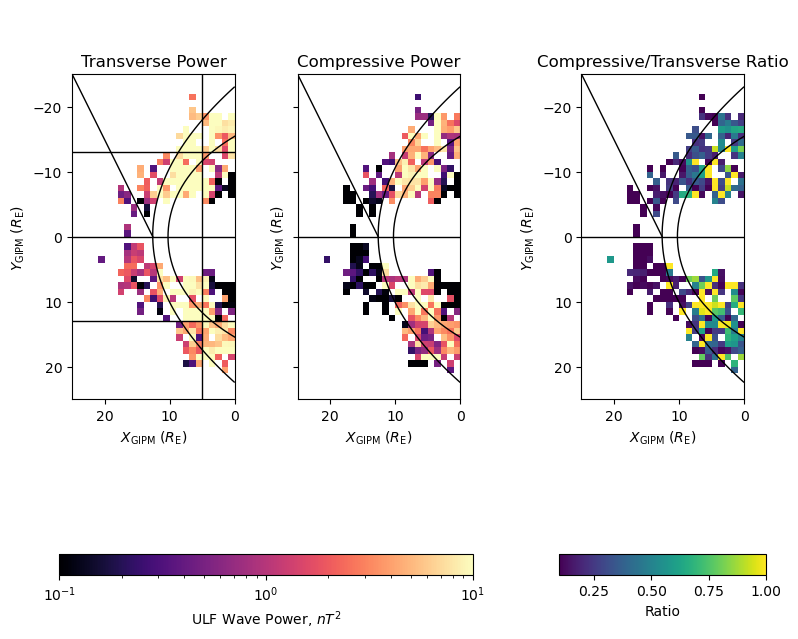

In [31]:
binned_plot_spec(mean_para_highspir_5_10,mean_perp_highspir_5_10,para_perp_highspir_5_10, 'Spiral', 0.1, 10, cmap_choice = 'multi')

In [8]:
#now search for only results in given bins + with close to typical power in that bin

X_lb = 11
X_ub = 12
Y_lb = -12
Y_ub = -11
mask_x = df_highspir_5_10.loc[(df_highspir_5_10['GIPM X']>= X_lb) & (df_highspir_5_10['GIPM X'] < X_ub)]
mask_xy = mask_x.loc[(mask_x['GIPM Y']>= Y_lb) & (mask_x['GIPM Y'] < Y_ub)]

In [9]:
mask_xy

,GIPM X,GIPM Y,GIPM Z,B min,B mean,B max,B median,B standard deviation,cone angle,M_A,ULF Parallel Power,ULF Perpendicular Power
datetime,,,,,,,,,,,,
2002-04-01 00:53:00,11.665367,-11.396423,-3.644420,0.457836,0.981778,1.282551,0.996420,0.108081,49.145004,7.970000,0.266298,5.267214
2002-04-01 00:57:00,11.727938,-11.195184,-4.305474,0.440739,1.045282,1.740234,1.034680,0.220878,45.106395,8.120000,1.198084,6.573824
2002-04-01 01:09:00,11.615316,-11.615737,-2.997149,0.949895,1.020515,1.264176,1.006839,0.051193,51.825818,8.300000,0.011596,0.780156
2002-04-01 01:21:00,11.399170,-11.272374,-4.529774,0.713230,1.023462,1.192628,1.024873,0.050528,59.040538,8.333333,0.010578,0.507501
2002-04-01 01:25:00,11.389511,-11.356351,-4.112072,0.508910,0.978245,1.226228,0.986396,0.085781,55.915161,8.360000,0.128045,1.143640


In [3]:
#now list all names of spectra files and find the matching spectra 

#str form 'YYYY-MM-DD HH:MM:SS'
interval_str = '2002-04-01 00:53:00'

#relevant times

list_spec = []

path_spec = "/Users/apx059/Documents/Full_Spectra/**"

for path in glob.glob(path_spec, recursive=True):
    list_spec.append(path)
    
#list with only files, not folders
spec_csvs = []

for element in list_spec:
    if interval_str in element:
            spec_csvs.append(element)
        
spec_dfs = []

for element in spec_csvs:
    if 'C1' in element:
        f_df = pd.read_csv(element)
        spec_dfs.append(f_df)


In [4]:
spec_csv = "/Users/apx059/Documents/Full_Spectra/Fourier_Spectra_2002/2002-04-01 00:53:00FS_C1.csv"
f_df = pd.read_csv(spec_csv)

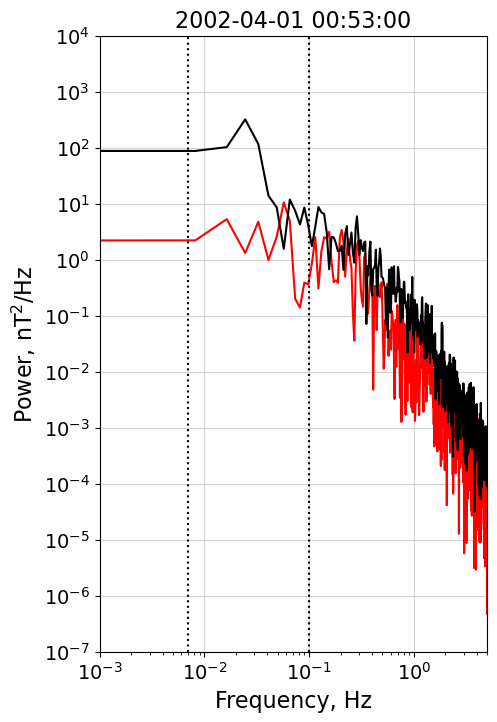

In [14]:
frequency = f_df['Freq']
perp_power = f_df['Perp 1 Power'] + f_df['Perp 2 Power']
para_power = f_df['Parallel Power']

int_lower_lim = 7*(10**(-3))
int_upper_lim = 100*(10**(-3))

fig, ax = plt.subplots(figsize = (5, 8))

ax.set_title('2002-04-01 00:53:00')
ax.plot(frequency, para_power, color="red", label='Parallel Power')
ax.plot(frequency, perp_power, color="black", label='Perpendicular Power')
#ax.plot(x_array, y_array, color="blue", label='-5/3 Slope')
#plt.xlabel('Period (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Power, $\mathrm{nT^2/Hz}$')
ax.set_xlabel('Frequency, Hz')
ax.set_xlim(0.001, 5)
ax.set_ylim(0.0000001, 10000)
#ax.set_ylim(0.001, 100_000)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
#ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10))
ax.vlines(x=int_lower_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Lower Bound')
#ax.vlines(x=dl_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dashed', label='De Lauretis Freq')
#ax.vlines(x=tak_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', label='Takahashi Freq')
#ax.vlines(x=lowfreq_lim, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', color='k', label='2 min window freq')
ax.vlines(x=int_upper_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Upper Bound')
#ax.legend(loc='lower center')
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=16) 

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')

In [41]:
#now search for only results in given bins + with close to typical power in that bin

X_lb_1 = 11
X_ub_1 = 12
Y_lb_1 = 11
Y_ub_1 = 12
mask_x_1 = df_highspir_5_10.loc[(df_highspir_5_10['GIPM X']>= X_lb_1) & (df_highspir_5_10['GIPM X'] < X_ub_1)]
mask_xy_1 = mask_x_1.loc[(mask_x_1['GIPM Y']>= Y_lb_1) & (mask_x_1['GIPM Y'] < Y_ub_1)]

In [25]:
mask_xy_1

,GIPM X,GIPM Y,GIPM Z,B min,B mean,B max,B median,B standard deviation,cone angle,M_A,ULF Parallel Power,ULF Perpendicular Power
datetime,,,,,,,,,,,,
2002-02-01 21:03:00,11.286398,11.028374,4.208179,0.914113,1.061983,1.12877,1.078861,0.048276,46.381581,7.85,0.012487,0.114866


In [11]:
spec_csv_1 = "/Users/apx059/Documents/Full_Spectra/Fourier_Spectra_2002/2002-02-01 21:03:00FS_C1.csv"
f_df_1 = pd.read_csv(spec_csv_1)

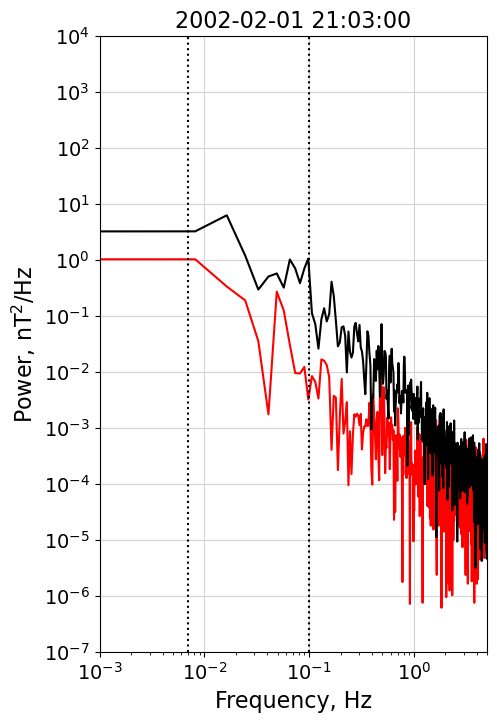

In [26]:
frequency = f_df_1['Freq']
perp_power = f_df_1['Perp 1 Power'] + f_df_1['Perp 2 Power']
para_power = f_df_1['Parallel Power']

int_lower_lim = 7*(10**(-3))
int_upper_lim = 100*(10**(-3))

fig, ax = plt.subplots(figsize = (5, 8))

ax.set_title('2002-02-01 21:03:00')
ax.plot(frequency, para_power, color="red", label='Parallel Power')
ax.plot(frequency, perp_power, color="black", label='Perpendicular Power')
#ax.plot(x_array, y_array, color="blue", label='-5/3 Slope')
#plt.xlabel('Period (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Power, $\mathrm{nT^2/Hz}$')
ax.set_xlabel('Frequency, Hz')
ax.set_xlim(0.001, 5)
ax.set_ylim(0.0000001, 10000)
#ax.set_ylim(0.001, 100_000)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
#ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10))
ax.vlines(x=int_lower_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Lower Bound')
#ax.vlines(x=dl_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dashed', label='De Lauretis Freq')
#ax.vlines(x=tak_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', label='Takahashi Freq')
#ax.vlines(x=lowfreq_lim, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', color='k', label='2 min window freq')
ax.vlines(x=int_upper_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Upper Bound')
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=16) 

#ax.legend(loc='lower center')
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')

In [43]:
#quasi parallel m'sheath:

X_lb_2 = 5
X_ub_2 = 6
Y_lb_2 = -14
Y_ub_2 = -13
mask_x_2 = df_highspir_5_10.loc[(df_highspir_5_10['GIPM X']>= X_lb_2) & (df_highspir_5_10['GIPM X'] < X_ub_2)]
mask_xy_2 = mask_x_2.loc[(mask_x_2['GIPM Y']>= Y_lb_2) & (mask_x_2['GIPM Y'] < Y_ub_2)]

In [44]:
mask_xy_2

,GIPM X,GIPM Y,GIPM Z,B min,B mean,B max,B median,B standard deviation,cone angle,M_A,ULF Parallel Power,ULF Perpendicular Power
datetime,,,,,,,,,,,,
2002-05-22 07:10:00,5.097548,-13.149246,3.307482,0.592495,1.930833,2.860366,1.957293,0.442215,52.260034,5.070000,6.311864,38.254866
2002-05-22 07:18:00,5.102578,-13.650155,-0.141913,0.133470,1.515344,2.655943,1.555213,0.429729,52.299572,5.060000,5.582778,8.118586
2002-05-22 07:22:00,5.116515,-13.615663,-1.091860,0.172140,1.696855,2.708897,1.746847,0.385342,51.939863,5.030000,1.362527,4.760890
2002-05-22 08:14:00,5.612009,-13.484803,-1.744819,1.037586,2.882860,3.499657,2.940775,0.307341,50.927838,5.000000,0.338677,4.089400
2002-05-22 08:18:00,5.376134,-13.647695,1.637993,2.349029,2.818305,3.449960,2.835671,0.190925,53.081062,5.077778,1.014028,5.748921
2002-05-22 08:22:00,5.499287,-13.900198,-0.399625,1.553276,2.812369,3.506726,2.855436,0.271137,54.699573,5.277778,1.641675,27.788749
2002-05-22 08:26:00,5.667143,-13.376746,-4.186642,1.775070,3.047695,4.010678,3.050221,0.309786,55.223082,5.433333,1.665974,7.167983


In [20]:
spec_csv_2 = "/Users/apx059/Documents/Full_Spectra/Fourier_Spectra_2002/2002-05-22 07:10:00FS_C1.csv"
f_df_2 = pd.read_csv(spec_csv_2)

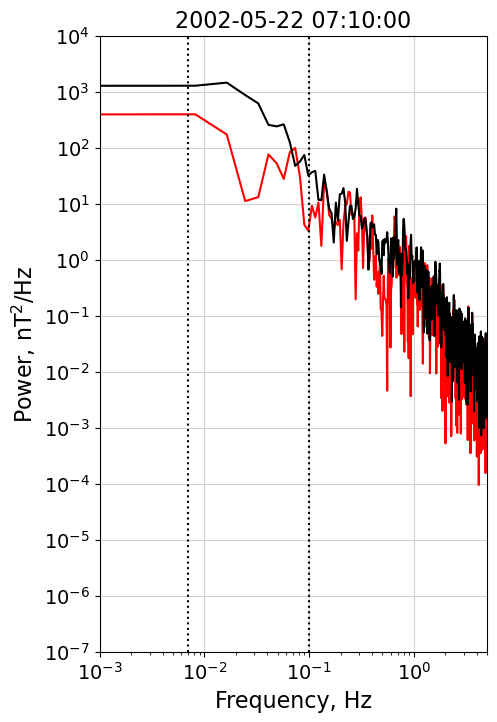

In [24]:
frequency = f_df_2['Freq']
perp_power = f_df_2['Perp 1 Power'] + f_df_2['Perp 2 Power']
para_power = f_df_2['Parallel Power']

int_lower_lim = 7*(10**(-3))
int_upper_lim = 100*(10**(-3))

fig, ax = plt.subplots(figsize = (5, 8))

ax.set_title('2002-05-22 07:10:00')

ax.plot(frequency, para_power, color="red", label='Parallel Power')
ax.plot(frequency, perp_power, color="black", label='Perpendicular Power')
#ax.plot(x_array, y_array, color="blue", label='-5/3 Slope')
#plt.xlabel('Period (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Power, $\mathrm{nT^2/Hz}$')
ax.set_xlabel('Frequency, Hz')
ax.set_xlim(0.001, 5)
ax.set_ylim(0.0000001, 10000)
#ax.set_ylim(0.001, 100_000)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
#ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10))
ax.vlines(x=int_lower_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Lower Bound')
#ax.vlines(x=dl_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dashed', label='De Lauretis Freq')
#ax.vlines(x=tak_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', label='Takahashi Freq')
#ax.vlines(x=lowfreq_lim, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', color='k', label='2 min window freq')
ax.vlines(x=int_upper_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Upper Bound')
#ax.legend(loc='lower center')
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=16) 

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')

In [47]:
#quasi perp m'sheath:

X_lb_3 = 5
X_ub_3 = 6
Y_lb_3 = 13
Y_ub_3 = 14
mask_x_3 = df_highspir_5_10.loc[(df_highspir_5_10['GIPM X']>= X_lb_3) & (df_highspir_5_10['GIPM X'] < X_ub_3)]
mask_xy_3 = mask_x_3.loc[(mask_x_3['GIPM Y']>= Y_lb_3) & (mask_x_3['GIPM Y'] < Y_ub_3)]

In [48]:
mask_xy_3

,GIPM X,GIPM Y,GIPM Z,B min,B mean,B max,B median,B standard deviation,cone angle,M_A,ULF Parallel Power,ULF Perpendicular Power
datetime,,,,,,,,,,,,
2002-12-14 02:03:00,5.891341,13.316124,-4.802665,2.828392,3.309036,3.735575,3.321628,0.202162,58.860640,5.72,0.830699,1.158068
2002-12-16 09:37:00,5.455819,13.322300,0.597582,2.519756,3.781334,4.618676,3.873366,0.471317,53.821573,5.97,2.008655,5.999635


In [18]:
spec_csv_3 = "/Users/apx059/Documents/Full_Spectra/Fourier_Spectra_2002/2002-12-14 02:03:00FS_C1.csv"
f_df_3 = pd.read_csv(spec_csv_3)

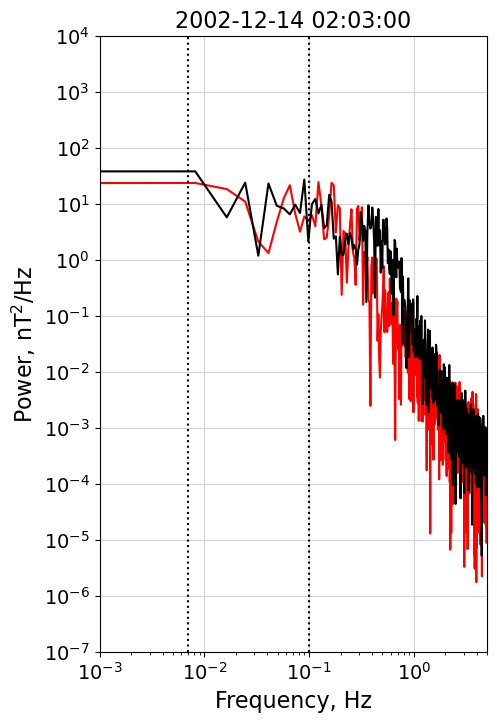

In [25]:
frequency = f_df_3['Freq']
perp_power = f_df_3['Perp 1 Power'] + f_df_3['Perp 2 Power']
para_power = f_df_3['Parallel Power']

int_lower_lim = 7*(10**(-3))
int_upper_lim = 100*(10**(-3))

fig, ax = plt.subplots(figsize = (5, 8))

ax.set_title('2002-12-14 02:03:00')
ax.plot(frequency, para_power, color="red", label='Parallel Power')
ax.plot(frequency, perp_power, color="black", label='Perpendicular Power')
#ax.plot(x_array, y_array, color="blue", label='-5/3 Slope')
#plt.xlabel('Period (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Power, $\mathrm{nT^2/Hz}$')
ax.set_xlabel('Frequency, Hz')
ax.set_xlim(0.001, 5)
ax.set_ylim(0.0000001, 10000)
#ax.set_ylim(0.001, 100_000)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
#ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10))
ax.vlines(x=int_lower_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Lower Bound')
#ax.vlines(x=dl_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dashed', label='De Lauretis Freq')
#ax.vlines(x=tak_freq, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', label='Takahashi Freq')
#ax.vlines(x=lowfreq_lim, ymin = 0.1, ymax = 100_000_000, linestyles='dotted', color='k', label='2 min window freq')
ax.vlines(x=int_upper_lim, ymin = 0.0000001, ymax = 10000, linestyles='dotted', color='k', label='Upper Bound')
#ax.legend(loc='lower center')
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=16) 

ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')

In [27]:
#plotting function but now with location marked on!

def binned_plot_new():
    x = np.linspace(0, 20, 100) #x coordinates (Re)
    y = np.linspace(-30, 30, 100) #y coordinates (Re)
    z = 0 #z coordinates in Re

    [Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

    fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

    Xn = Xgipm
    Yn = Ygipm
    Zn = Zgipm
    f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

    norm = plt.Normalize(0.01,8)

    #tanfieldangle = y/x

    tan_angle_1 = np.tan(np.deg2rad(52.5))

    #magnetopause model, D = 2 nPa

    m_1 = 10.22
    m_2 = 1.29
    m_3 = 0.184
    m_4 = 8.14
    m_5 = 6.6
    m_6 = 0.58
    m_7 = -0.007
    m_8 = 0.024

    #use B_z =0
    B_z = 0
    D_p = 2

    alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

    tanh_angle = m_3*(B_z+m_4)
    r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

    pi = np.pi

    theta = np.arange(-pi/2, pi/2, 0.01)

    r_mod = (2/(1+np.cos(theta)))**alpha
    r = r_0*r_mod

    X_shue = r*(np.cos(theta))
    R_shue = r*(np.sin(theta))


    ###################
    fig = plt.figure(figsize=(8, 6.5))
    subfigs = fig.subfigures(1, 1)
    axsLeft = subfigs.subplots()
    #gs = gridspec.GridSpec(2, 2)
    #subfigs.suptitle('Mean $B_\\mathrm{CLUSTER}$/$B_\\mathrm{OMNI}$ Values, Feb 2001- Feb 2002, GIPM')
    
    #want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
    #without exceeding current bounds of plot
    inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
    X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]
    
    #SPIRAL
    x_s = X_BS_nose
    y_s = 0
    x_e = 25
    y_e = x_e*(-tan_angle_1)

    #want to also have line for just solar wind flow along y=0

    #x_mesh = np.arange(0, 25, bin_size) 
    #y_mesh = np.arange(-22, 22, bin_size)
    #col_array_1 = np.array(spir_list)
    #x_bin_ticks = int(25/bin_size)
    #y_bin_ticks = int(44/bin_size)
    #color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
    #color_grid_1 = np.rot90(color_grid_1)
    #color_grid_1 = np.flipud(color_grid_1)

    axsLeft.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    #axsLeft.hlines(y=-17, xmin= 0, xmax=25, linewidth=1, color='k')
    #axsLeft.hlines(y=-19, xmin= 0, xmax=25, linewidth=1, color='k')
    #axsLeft.hlines(y=14, xmin= 0, xmax=25, linewidth=1, color='k')
    #axsLeft.vlines(x=9, ymin= -30, ymax=30, linewidth=1, color='k')
    #axsLeft.vlines(x=8, ymin= -30, ymax=30, linewidth=1, color='k')
    #axsLeft.vlines(x=22, ymin= -30, ymax=30, linewidth=1, color='k')
    axsLeft.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)

    #axsLeft.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm)
    axsLeft.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    axsLeft.plot(X_shue, R_shue, linewidth=1, color='k')
    
    point_1_x = 11.665367
    point_1_x_lab = point_1_x - 1
    point_1_y = -11.396423
        
    point_2_x = 11.286398
    point_2_x_lab = point_2_x - 1
    point_2_y = 11.028374
        
    point_3_x =  5.097548
    point_3_x_lab = point_3_x - 1
    point_3_y = -13.149246
    
    point_4_x = 5.891341
    point_4_x_lab = point_4_x - 1
    point_4_y = 13.316124
    
    axsLeft.scatter(point_1_x, point_1_y, marker="o", c="blue", s=60)
    axsLeft.scatter(point_2_x, point_2_y, marker="o", c="blue", s=60)
    axsLeft.scatter(point_3_x, point_3_y, marker="o", c="blue", s=60)
    axsLeft.scatter(point_4_x, point_4_y, marker="o", c="blue", s=60)
    
    plt.text(point_1_x_lab, point_1_y, '1', color="maroon", weight= 'bold', fontsize=16)
    plt.text(point_2_x_lab, point_2_y, '2', color="maroon", weight = 'bold', fontsize=16)
    plt.text(point_3_x_lab, point_3_y, '3', color="maroon", weight = 'bold', fontsize=16)
    plt.text(point_4_x_lab, point_4_y, '4', color="maroon", weight = 'bold',fontsize=16)
    
    axsLeft.set_aspect('equal')
    axsLeft.set_title(r'Case Study Interval Locations')
    axsLeft.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    axsLeft.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    axsLeft.set_ylim(-25,25)
    axsLeft.set_xlim(0,22)
    axsLeft.xaxis.set_minor_locator(MultipleLocator(2))
    axsLeft.yaxis.set_minor_locator(MultipleLocator(2))
    axsLeft.invert_xaxis()
    axsLeft.invert_yaxis()
    
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14) 
    plt.rc('axes', labelsize=16) 

    #fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axsLeft)

    #plt.show()


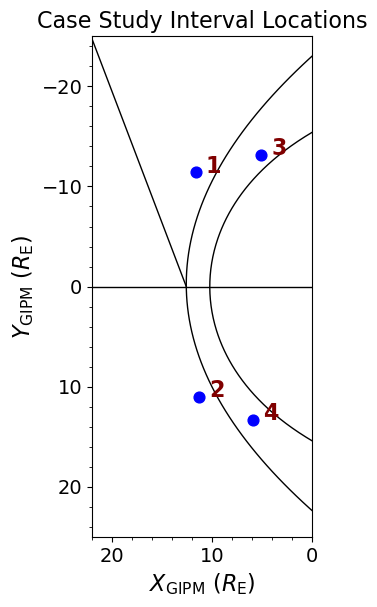

In [28]:
binned_plot_new()